# 互评作业2: 频繁模式与关联规则挖掘--3220200920刘晓晨
Github地址：https://github.com/LiuXiaochen-0920/Data-Mining

## 作业说明
### 1. 问题描述
利用所学数据挖掘技术，选择1个数据集进行频繁模式和关联规则挖掘，并撰写分析报告。

### 2. 数据集
所选数据集为：<br>  
* [Oakland Crime Statistics 2011 to 2016](https://www.kaggle.com/cityofoakland/oakland-crime-statistics-2011-to-2016)

### 3. 背景
这是一个小项目，通过2011-2016年的数据集来寻找加州奥克兰的犯罪细节。
作为一点背景信息，数据集中有一些犯罪名称，在这里做一下说明。
例如，“priority 1 & 2”的定义如下:
* “priority 1”是一种紧急犯罪，例如，警灯和警报器被授权，持械抢劫，警察被击倒等。
* “priority 2”被认为是不那么紧急的，例如，授权了灯和警报器，但要遵守基本的交通规则。

### 4. 数据分析要求
* 对数据集进行处理，转换成适合进行关联规则挖掘的形式；
* 找出频繁模式；
* 导出关联规则，计算其支持度和置信度;
* 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；
* 对挖掘结果进行分析；
* 可视化展示。

# 频繁模式与关联规则挖掘

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings 
import scipy as sp
import seaborn as sns
import json
import math
import re
import sys
import csv
from pandas import Timestamp
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from progressbar import *

In [46]:
warnings.filterwarnings('ignore')

In [47]:
# 导入文件
df_2011 = pd.read_csv('./input/oakland-crime-statistics-2011-to-2016/records-for-2011.csv', parse_dates=['Create Time', 'Closed Time'])
df_2012 = pd.read_csv('./input/oakland-crime-statistics-2011-to-2016/records-for-2012.csv', parse_dates=['Create Time', 'Closed Time'])
df_2013 = pd.read_csv('./input/oakland-crime-statistics-2011-to-2016/records-for-2013.csv', parse_dates=['Create Time', 'Closed Time'])
df_2014 = pd.read_csv('./input/oakland-crime-statistics-2011-to-2016/records-for-2014.csv', parse_dates=['Create Time', 'Closed Time'])
df_2015 = pd.read_csv('./input/oakland-crime-statistics-2011-to-2016/records-for-2015.csv', parse_dates=['Create Time', 'Closed Time'])
df_2016 = pd.read_csv('./input/oakland-crime-statistics-2011-to-2016/records-for-2016.csv', parse_dates=['Create Time', 'Closed Time'])

In [48]:
list_dfs = [df_2011, df_2012, df_2013, df_2014, df_2015, df_2016]

In [49]:
# 查看所有数据集的前几行数据
def shapes():
    x = 0
    for i in list_dfs:
        print(f"Shape of dataset for {x+2011} is {i.shape}")
        x+=1
shapes()

Shape of dataset for 2011 is (180016, 10)
Shape of dataset for 2012 is (187431, 11)
Shape of dataset for 2013 is (188052, 10)
Shape of dataset for 2014 is (187480, 11)
Shape of dataset for 2015 is (192581, 10)
Shape of dataset for 2016 is (110828, 10)


In [50]:
df_2011.head()

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2011-01-01 00:00:00,ST&SAN PABLO AV,1.0,06X,1.0,PDOA,POSSIBLE DEAD PERSON,LOP110101000001,2011-01-01 00:28:17
1,OP,2011-01-01 00:01:11,ST&HANNAH ST,1.0,07X,1.0,415GS,415 GUNSHOTS,LOP110101000002,2011-01-01 01:12:56
2,OP,2011-01-01 00:01:25,ST&MARKET ST,1.0,10Y,2.0,415GS,415 GUNSHOTS,LOP110101000003,2011-01-01 00:07:20
3,OP,2011-01-01 00:01:35,PRENTISS ST,2.0,21Y,2.0,415GS,415 GUNSHOTS,LOP110101000005,2011-01-01 00:02:28
4,OP,2011-01-01 00:02:10,AV&FOOTHILL BLVD,2.0,20X,1.0,415GS,415 GUNSHOTS,LOP110101000004,2011-01-01 00:50:04


In [51]:
df_2012.head()

,Agency,Create Time,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time,Location 1,Zip Codes
0,OP,2012-01-01 00:00:25,2.0,32Y,2.0,415GS,415 GUNSHOTS,LOP120101000004,2012-01-01 00:40:27,"{'human_address': '{""address"": ""OLIVE ST"", ""ci...",NaN
1,OP,2012-01-01 00:00:27,2.0,30Y,2.0,415GS,415 GUNSHOTS,LOP120101000003,2012-01-01 01:34:31,"{'human_address': '{""address"": ""AV&MACARTHUR B...",NaN
2,OP,2012-01-01 00:00:48,1.0,06X,2.0,949,SUSPICIOUS VEHICLE,LOP120101000005,2012-01-01 01:18:38,"{'human_address': '{""address"": ""SYCAMORE ST"", ...",NaN
3,OP,2012-01-01 00:00:58,2.0,35X,2.0,415GS,415 GUNSHOTS,LOP120101000008,2012-01-01 02:37:00,"{'human_address': '{""address"": ""AV&MACARTHUR B...",NaN
4,OP,2012-01-01 00:01:14,1.0,02Y,2.0,415GS,415 GUNSHOTS,LOP120101000007,2012-01-01 02:12:39,"{'human_address': '{""address"": ""ST&WOOD ST"", ""...",NaN


In [52]:
df_2013.head()

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2013-01-01 00:00:00,D ST,2.0,33X,1.0,415GS,415 GUNSHOTS,LOP130101000002,2013-01-01 00:47:51
1,OP,2013-01-01 00:00:05,ARTHUR ST,2.0,30X,2.0,415GS,415 GUNSHOTS,LOP130101000004,2013-01-01 01:30:58
2,OP,2013-01-01 00:00:50,BRIDGE AV,2.0,23X,1.0,243E,BATTERY ON CO-HABITA,LOP130101000003,2013-01-01 05:05:50
3,OP,2013-01-01 00:02:16,AV&BROOKDALE AV,2.0,29X,2.0,415GS,415 GUNSHOTS,LOP130101000005,2013-01-01 01:37:27
4,OP,2013-01-01 00:02:47,AV&SAN LEANDRO ST,2.0,26Y,2.0,415GS,415 GUNSHOTS,LOP130101000006,2013-01-01 01:33:11


In [53]:
df_2014.head()

,Agency,Create Time,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time,Location 1,Zip Codes
0,OP,2014-01-01 00:00:00,1.0,02X,2,415GS,415 GUNSHOTS,LOP140101000001,2014-01-01 03:22:08,"{'human_address': '{""address"": ""LINDEN ST"", ""c...",NaN
1,OP,2014-01-01 00:00:00,2.0,26Y,2,415GS,415 GUNSHOTS,LOP140101000002,2014-01-01 02:56:31,"{'human_address': '{""address"": ""AV&INTERNATION...",NaN
2,OP,2014-01-01 00:00:00,2.0,30Y,2,415GS,415 GUNSHOTS,LOP140101000004,2014-01-01 00:49:53,"{'human_address': '{""address"": ""AV&MACARTHUR B...",NaN
3,OP,2014-01-01 00:00:00,2.0,30Y,2,415GS,415 GUNSHOTS,LOP140101000005,2014-01-01 02:51:11,"{'human_address': '{""address"": ""MACARTHUR BLVD...",NaN
4,OP,2014-01-01 00:01:04,2.0,35X,2,CODE7,SUBJECT ARMED WITH W,LOP140101000010,2014-01-01 05:33:22,"{'human_address': '{""address"": ""AV&DOWLING ST""...",NaN


In [54]:
df_2015.head()

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2015-01-01 00:01:59,S ELMHURST AV,P3,31Y,2,415,DISTURBING THE PEACE,LOP150101000003,2015-01-01 06:23:08
1,OP,2015-01-01 00:02:02,AV&D ST,P3,32X,2,415GS,415 GUNSHOTS,LOP150101000007,2015-01-01 01:44:40
2,OP,2015-01-01 00:02:06,BANCROFT AV,P3,30Y,2,933R,ALARM-RINGER,LOP150101000004,2015-01-01 02:12:39
3,OP,2015-01-01 00:03:16,MACARTHUR BLVD,P3,30Y,2,415GS,415 GUNSHOTS,LOP150101000005,2015-01-01 01:53:08
4,OP,2015-01-01 00:03:45,ST&ADELINE ST,P1,02X,2,415GS,415 GUNSHOTS,LOP150101000009,2015-01-01 00:37:09


In [55]:
df_2016.head()

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2016-01-01 00:00:57,ST&MARKET ST,P1,05X,2.0,415GS,415 GUNSHOTS,LOP160101000003,2016-01-01 00:32:30
1,OP,2016-01-01 00:01:25,AV&HAMILTON ST,P3,26Y,2.0,415GS,415 GUNSHOTS,LOP160101000005,2016-01-01 00:48:23
2,OP,2016-01-01 00:01:43,ST&CHESTNUT ST,P1,02X,2.0,415GS,415 GUNSHOTS,LOP160101000008,2016-01-01 00:21:24
3,OP,2016-01-01 00:01:48,WALLACE ST,P2,18Y,2.0,415GS,415 GUNSHOTS,LOP160101000007,2016-01-01 01:15:03
4,OP,2016-01-01 00:02:05,90TH AV,P3,34X,2.0,415GS,415 GUNSHOTS,LOP160101000009,2016-01-01 00:54:52


### 优先级分析

In [56]:
# 所有年份中所观察的优先罪案数目:
a = 0
for i in list_dfs:
    print(i[i['Priority']!=0].groupby(['Priority']).size().reset_index(name=str(f'Count in {a + 2011}')))
    a += 1
    print(' ')

   Priority  Count in 2011
0       1.0          36699
1       2.0         143314
 
   Priority  Count in 2012
0       1.0          41926
1       2.0         145504
 
   Priority  Count in 2013
0       1.0          43171
1       2.0         144859
 
   Priority  Count in 2014
0         1          42773
1         2         144707
 
   Priority  Count in 2015
0         1          42418
1         2         150162
 
   Priority  Count in 2016
0       1.0          24555
1       2.0          86272
 


array([[<AxesSubplot:title={'center':'Count in 2011'}, xlabel='Priority'>,
        <AxesSubplot:title={'center':'Count in 2012'}, xlabel='Priority'>,
        <AxesSubplot:title={'center':'Count in 2013'}, xlabel='Priority'>],
       [<AxesSubplot:title={'center':'Count in 2014'}, xlabel='Priority'>,
        <AxesSubplot:title={'center':'Count in 2015'}, xlabel='Priority'>,
        <AxesSubplot:title={'center':'Count in 2016'}, xlabel='Priority'>]],
      dtype=object)

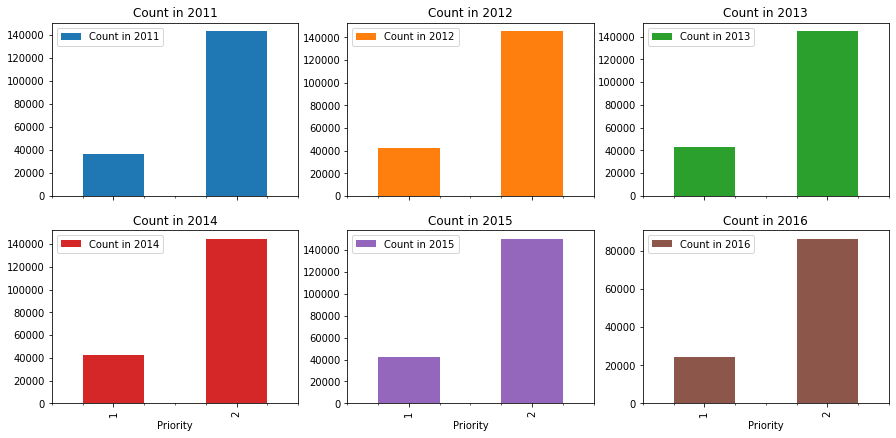

In [57]:
# 比较优先类型犯罪的柱状图
df = pd.DataFrame([
    [1, 36699, 41926, 43171, 42773, 42418, 24555],
    [2, 143314, 145504, 144859, 144707, 150162, 86272]
],
columns=['Priority']+[f'Count in {x}' for x in range(2011,2017)]
)

df.plot.bar(x='Priority', subplots=True, layout=(2,3), figsize=(15, 7))

在整个数据集中，犯罪率似乎保持稳定。在观察到的六年中，百分比差异的幅度很小。

### 区域ID分析

In [58]:
# 每个区域/位置/巡逻区域的平均优先级计数
def areaid_groupby():
    for i in list_dfs:
        print(i[i['Priority']!=0].groupby(['Area Id', 'Priority']).size())
        print(' ')
areaid_groupby()

Area Id  Priority
1.0      1.0         15348
         2.0         63804
2.0      1.0         14228
         2.0         53032
3.0      1.0          7095
         2.0         25603
dtype: int64
 
Area Id  Priority
1.0      1.0         21256
         2.0         79797
2.0      1.0         20618
         2.0         64345
dtype: int64
 
Area Id  Priority
1.0      1.0         23332
         2.0         81873
2.0      1.0         19773
         2.0         60795
dtype: int64
 
Area Id  Priority
1.0      1           1086
         2           3945
2.0      1            953
         2           2945
3.0      1             43
         2            165
4.0      1             58
         2            178
5.0      1             81
         2            239
dtype: int64
 
Area Id  Priority
P1       1           14950
         2           58190
P2       1            7345
         2           26078
P3       1           19870
         2           61759
PCW      1             201
         2             

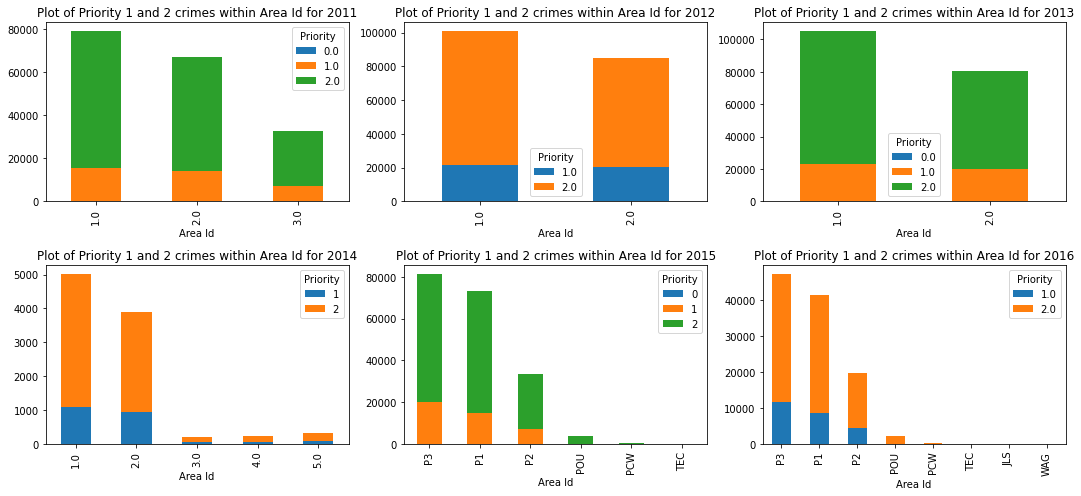

In [59]:
fig, axes= plt.subplots(2, 3)
for i, d in enumerate(list_dfs):
    ax = axes.flatten()[i]
    dplot = d[['Area Id', 'Priority']].pivot_table(index='Area Id', columns=['Priority'], aggfunc=len)
    dplot = (dplot.assign(total=lambda x: x.sum(axis=1))
                  .sort_values('total', ascending=False)
                  .head(10)
                  .drop('total', axis=1))
    dplot.plot.bar(ax=ax, figsize=(15, 7), stacked=True)
    ax.set_title(f"Plot of Priority 1 and 2 crimes within Area Id for {i+2011}")
    plt.tight_layout()

将每个数据集的优先级为1和优先级为2的犯罪总数相加，我们可以看到这两种犯罪都有所增加。

### 巡逻区域分析

In [60]:
# 按优先级显示的巡逻区域的值计数
for i in list_dfs:
    print(i[i['Priority']!=0].groupby(['Beat', 'Priority']).size())
    print(' ')

Beat  Priority
01X   1.0          394
      2.0         1816
02X   1.0          644
      2.0         1970
02Y   1.0          661
                  ... 
35X   2.0         2979
35Y   1.0          269
      2.0         1687
PDT2  1.0            2
      2.0           18
Length: 116, dtype: int64
 
Beat  Priority
01X   1.0          493
      2.0         1700
02X   1.0          731
      2.0         2067
02Y   1.0          795
                  ... 
35X   2.0         3204
35Y   1.0          314
      2.0         1672
PDT2  1.0            5
      2.0           23
Length: 116, dtype: int64
 
Beat  Priority
01X   1.0          467
      2.0         1842
02X   1.0          850
      2.0         1863
02Y   1.0          791
                  ... 
35X   2.0         3049
35Y   1.0          305
      2.0         1645
PDT2  1.0            2
      2.0           16
Length: 116, dtype: int64
 
Beat  Priority
01X   1            481
      2           1839
02X   1            806
      2           2013
02Y  

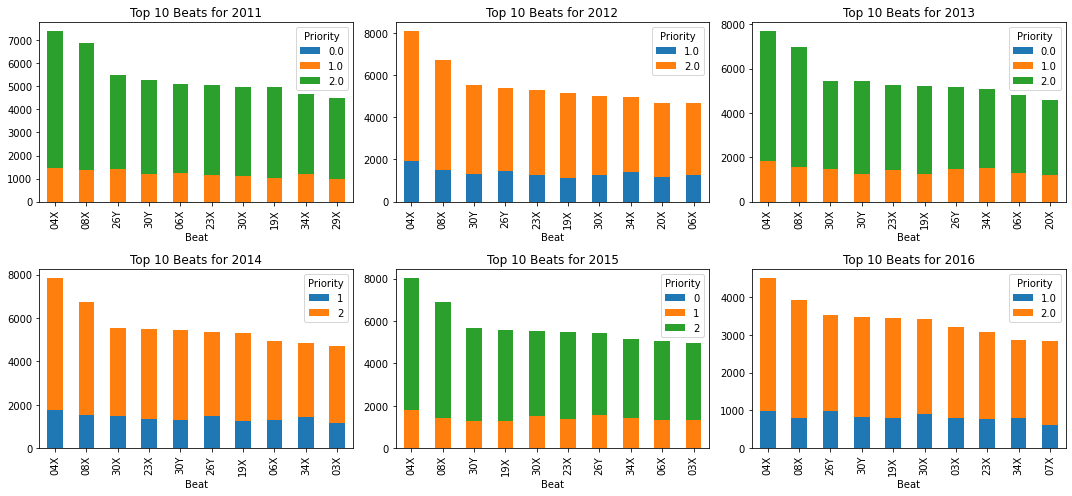

In [61]:
fig, axes = plt.subplots(2, 3)
for i, d in enumerate(list_dfs):
    ax = axes.flatten()[i]
    dplot = d[['Beat', 'Priority']].pivot_table(index='Beat', columns=['Priority'], aggfunc=len)
    dplot = (dplot.assign(total=lambda x: x.sum(axis=1))
                  .sort_values('total', ascending=False)
                  .head(10)
                  .drop('total', axis=1))
    dplot.plot.bar(ax=ax, figsize=(15, 7), stacked=True)
    ax.set_title(f"Top 10 Beats for {i+ 2011}")
    plt.tight_layout()

### 事件类型描述(事件类型id)分析

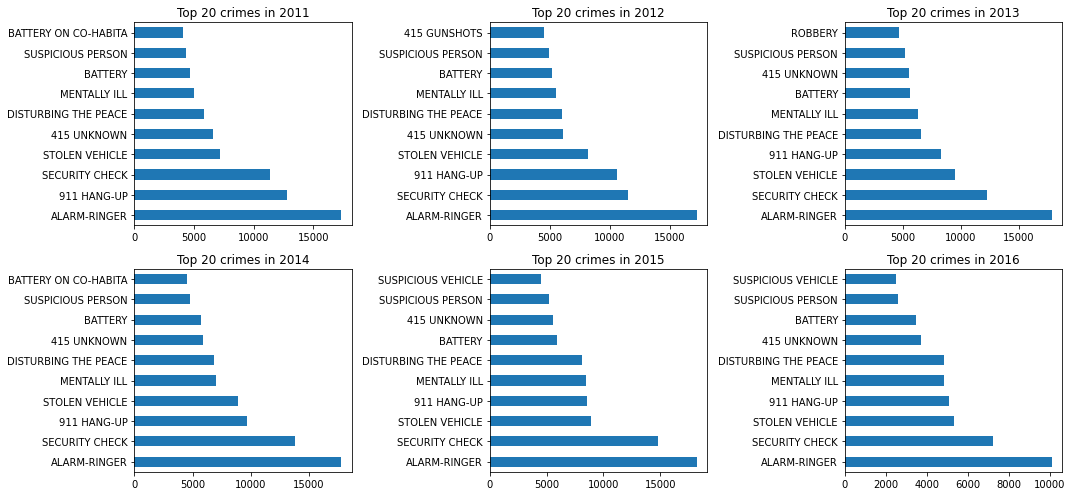

In [62]:
# 数据集中最常见的20种犯罪
df1 = df_2011['Incident Type Description'].value_counts()[:10]
df2 = df_2012['Incident Type Description'].value_counts()[:10]
df3 = df_2013['Incident Type Description'].value_counts()[:10]
df4 = df_2014['Incident Type Description'].value_counts()[:10]
df5 = df_2015['Incident Type Description'].value_counts()[:10]
df6 = df_2016['Incident Type Description'].value_counts()[:10]
list_df = [df1, df2, df3, df4, df5, df6]
fig, axes = plt.subplots(2, 3)
for d, i in zip(list_df, range(6)):
    ax=axes.ravel()[i];
    ax.set_title(f"Top 20 crimes in {i+2011}")
    d.plot.barh(ax=ax, figsize=(15, 7))
    plt.tight_layout()

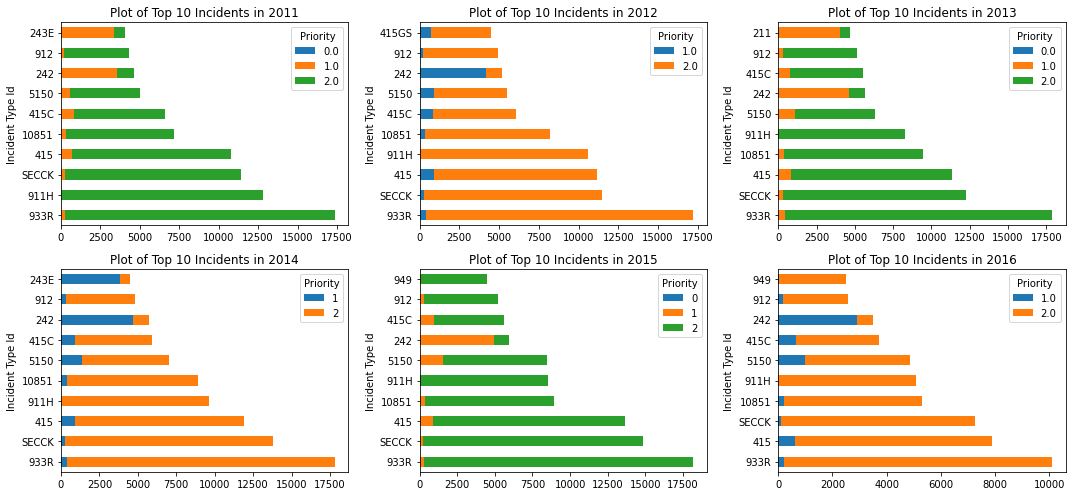

In [63]:
fig, axes = plt.subplots(2, 3)
for i, d in enumerate(list_dfs):
    ax = axes.flatten()[i]
    dplot = d[['Incident Type Id', 'Priority']].pivot_table(index='Incident Type Id', columns='Priority',aggfunc=len)
    dplot = (dplot.assign(total=lambda x: x.sum(axis=1))
                  .sort_values('total', ascending=False)
                  .head(10)
                  .drop('total', axis=1))
    dplot.plot.barh(ax=ax, figsize=(15, 7), stacked=True)
    ax.set_title(f"Plot of Top 10 Incidents in {i+2011}")
    plt.tight_layout()

两个图表显示'事件类型描述'以及它的Id。第一幅图显示“报警铃声”是迄今为止报告最多的犯罪，然而在图2中我们可以看到只有一小部分是优先级1。通过6个数据集，我们可以看到“Battery/242”是报告的最高优先级犯罪。

### 时间分析

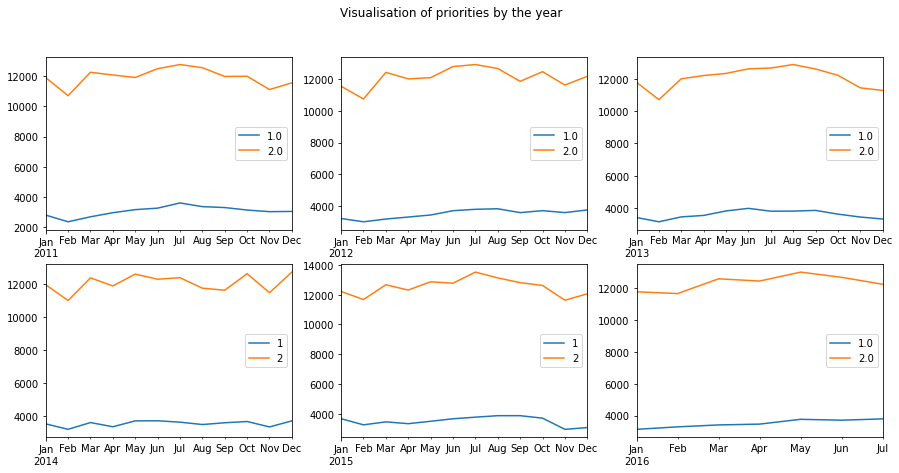

In [64]:
# 每月优先级犯罪总数
pri_count_list = [df_2011.groupby(['Priority', df_2011['Create Time'].dt.to_period('m')]).Priority.count(),
                  df_2012.groupby(['Priority', df_2012['Create Time'].dt.to_period('m')]).Priority.count(),
                  df_2013.groupby(['Priority', df_2013['Create Time'].dt.to_period('m')]).Priority.count(),
                  df_2014.groupby(['Priority', df_2014['Create Time'].dt.to_period('m')]).Priority.count(),
                  df_2015.groupby(['Priority', df_2015['Create Time'].dt.to_period('m')]).Priority.count(),
                  df_2016.groupby(['Priority', df_2016['Create Time'].dt.to_period('m')]).Priority.count()]
fig, axes = plt.subplots(2, 3)
for d, ax in zip(pri_count_list, axes.ravel()):
    plot_df1 = d.unstack('Priority').loc[:, 1]
    plot_df2 = d.unstack('Priority').loc[:, 2]
    plot_df1.index = pd.PeriodIndex(plot_df1.index.tolist(), freq='m')
    plot_df2.index = pd.PeriodIndex(plot_df2.index.tolist(), freq='m')
    plt.suptitle('Visualisation of priorities by the year')
    plot_df1.plot(ax=ax, legend=True, figsize=(15, 7))
    plot_df2.plot(ax=ax, legend=True, figsize=(15, 7))

可视化显示，在每一年里，第二优先犯罪似乎在7月/ 8月左右达到顶峰。除了2014年，这个数字似乎有所下降。2016年的图表显示了一个不确定的图表，因为数据集只有7个月的时间跨度。

### Apriori算法

### 关联规则
1. 支持度
$$Sup(x)=\frac{count(X)}{all_data}$$
2. 执行度
$$conf(X \to Y)=\frac{Sup(X \cup Y}{Sup(X)}$$
3. Lift
$$lift(X \to Y)=\frac{Sup(X \cup Y}{Sup(X) \times Sup(Y)}$$
4. Jaccard
$$Jaccard(X \to Y) = \frac{X \cup Y}{Sup(X) + Sup(Y) - Sup(X \cup Y)}$$


In [74]:
#首先找出所有频繁项集，然后由频繁项集产生强关联规则
class Association(object):
    def __init__(self, min_support = 0.1, min_confidence = 0.5):
        self.min_support = min_support         # 最小支持度
        self.min_confidence = min_confidence   #  最小置信度

    def apriori(self, dataset):
        """
        Apriori algorithm
        dataset:数据集，类型为一个list，list中每个元素是一个dict，key为属性名，value为对应属性的取值
        返回生成的频繁项集
        """
        C1 = self.create_C1(dataset)
        dataset = [set(data) for data in dataset]
        L1, support_data = self.scan_D(dataset, C1)
        L = [L1]
        k = 2
        while len(L[k-2]) > 0:
            Ck = self.apriori_gen(L[k-2], k)
            Lk, support_k = self.scan_D(dataset, Ck)
            support_data.update(support_k)
            L.append(Lk)
            k += 1
        return L, support_data

    def create_C1(self, dataset):
        """
        构建全部可能的单元素候选项集合(list)
        每个单元素候选项：（属性名，属性取值）
        """
        C1 = []
        progress = ProgressBar()
        for data in progress(dataset):
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        return [frozenset(item) for item in C1]

    def scan_D(self, dataset, Ck):
        """
        根据待选项集Ck的情况，判断数据集D中Ck元素的出现频率
        过滤掉低于最小支持度的项集
        """
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        support_data = dict()
        # 过滤非频繁项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_support:
                return_list.insert(0, key)
            support_data[key] = support
        return return_list, support_data

    def apriori_gen(self, Lk, k):
        #合并元素时容易出现重复,针对包含k个元素的频繁项集，对比每个频繁项集第k-2位是否一致
        return_list = []
        len_Lk = len(Lk)
        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                # 第k-2个项相同时，将两个集合合并
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list

    def generate_rules(self, L, support_data):
        """
        强关联规则
        基于Apriori算法，首先从一个频繁项集开始，接着创建一个规则列表，
        其中规则右部只包含一个元素，然后对这些规则进行测试。
        接下来合并所有的剩余规则列表来创建一个新的规则列表，
        其中规则右部包含两个元素。这种方法称作分级法。
        L: 频繁项集
        support_data: 频繁项集对应的支持度
        返回强关联规则列表
        """
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self.rules_from_conseq(freq_set, H1, support_data, big_rules_list)
                else:
                    self.cal_conf(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

    def rules_from_conseq(self, freq_set, H, support_data, big_rules_list):
        # H->出现在规则右部的元素列表
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self.apriori_gen(H, m+1)
            Hmp1 = self.cal_conf(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                self.rules_from_conseq(freq_set, Hmp1, support_data, big_rules_list)

    def cal_conf(self, freq_set, H, support_data, big_rules_list):
        # 评估生成的规则
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            jaccard = sup / (support_data[freq_set - conseq] + support_data[conseq] - sup)
            if conf >= self.min_confidence:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift,jaccard))
                prunedH.append(conseq)
        return prunedH

In [75]:
class OCS_dataset():
    def __init__(self,data_file_path,result_path,feature_list=None):
        self.data_file_path = data_file_path
        self.feature_list = feature_list
        self.result_path = result_path

    def set_feature_list(self,feature_list):
        self.feature_list = feature_list
        
    def set_data_file_path(self,data_file_path):
        self.data_file_path = data_file_path
    
    def set_result_path(result_path):
        self.result_path = result_path
    
    def data_read(self):

        data2011 = pd.read_csv(self.data_file_path+"/records-for-2011.csv", encoding="utf-8")
        data2012 = pd.read_csv(self.data_file_path+"/records-for-2012.csv", encoding="utf-8")
        data2013 = pd.read_csv(self.data_file_path+"/records-for-2013.csv", encoding="utf-8")
        data2014 = pd.read_csv(self.data_file_path+"/records-for-2014.csv", encoding="utf-8")
        data2015 = pd.read_csv(self.data_file_path+"/records-for-2015.csv", encoding="utf-8")
        data2016 = pd.read_csv(self.data_file_path+"/records-for-2016.csv", encoding="utf-8")
        
        data2012.rename(columns={"Location 1": "Location"}, inplace = True)
        data2013.rename(columns={"Location ": "Location"}, inplace = True)
        data2014.rename(columns={"Location 1": "Location"}, inplace = True)

        order=["Agency", "Location", "Area Id", "Beat", "Priority", 
               "Incident Type Id", "Incident Type Description", "Event Number"]
        data2011_2 = data2011[order]; data2012_2 = data2012[order]; data2013_2 = data2013[order]
        data2014_2 = data2014[order]; data2015_2 = data2015[order]; data2016_2 = data2016[order]

        data_all = pd.concat([data2011_2, data2012_2, data2013_2, data2014_2, data2015_2, data2016_2],
                             axis=0)
        print("合并后的数据集:"); print(data_all.info())
        data_all = data_all.dropna(how='any')

        return data_all


    def mining(self,min_support = 0.1, min_confidence = 0.5,head_n=None):
        out_path = self.result_path
        association = Association(min_support=min_support,min_confidence=min_confidence)
        data_all = self.data_read()
        rows = None
        if head_n is None:
          rows = data_all.values.tolist()
        else:
          rows = data_all.head(head_n).values.tolist()

        # 将数据转为数据字典存储
        dataset = []
        feature_names = ["Agency", "Location", "Area Id", "Beat", "Priority", 
                             "Incident Type Id", "Incident Type Description", "Event Number"]
        for data_line in rows:
            data_set = []
            for i, value in enumerate(data_line):
                if not value:
                    data_set.append((feature_names[i], 'NA'))
                else:
                    data_set.append((feature_names[i], value))
            dataset.append(data_set)
        print("挖掘开始")
        # 获取频繁项集
        freq_set, sup_rata = association.apriori(dataset)
        sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)
        # 获取强关联规则列表
        strong_rules_list = association.generate_rules(freq_set, sup_rata)
        strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)

        print("挖掘完成！")
        # 将频繁项集输出到结果文件
        freq_set_file = open(os.path.join(out_path, 'fterms.json'), 'w')
        for (key, value) in sup_rata_out:
            result_dict = {'set': None, 'sup': None}
            set_result = list(key)
            sup_result = value
            if sup_result < association.min_support:
                continue
            result_dict['set'] = set_result
            result_dict['sup'] = sup_result
            json_str = json.dumps(result_dict, ensure_ascii=False)
            freq_set_file.write(json_str + '\n')
        freq_set_file.close()

        # 将关联规则输出到结果文件
        rules_file = open(os.path.join(out_path, 'rules.json'), 'w')
        for result in strong_rules_list:
            result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
            X_set, Y_set, sup, conf, lift, jaccard = result
            result_dict['X_set'] = list(X_set)
            result_dict['Y_set'] = list(Y_set)
            result_dict['sup'] = sup
            result_dict['conf'] = conf
            result_dict['lift'] = lift
            result_dict['jaccard'] = jaccard

            json_str = json.dumps(result_dict, ensure_ascii=False)
            rules_file.write(json_str + '\n')
        rules_file.close()
        print("结果存储完成！")

In [77]:
ocs = OCS_dataset(data_file_path="./input/oakland-crime-statistics-2011-to-2016",
                 result_path="./ocs_result")
ocs.mining(min_support = 0.1, min_confidence = 0.5,head_n=50000)

合并后的数据集:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046388 entries, 0 to 110827
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Agency                     1046384 non-null  object 
 1   Location                   1046276 non-null  object 
 2   Area Id                    864023 non-null   object 
 3   Beat                       1040583 non-null  object 
 4   Priority                   1046384 non-null  float64
 5   Incident Type Id           1046384 non-null  object 
 6   Incident Type Description  1045996 non-null  object 
 7   Event Number               1046384 non-null  object 
dtypes: float64(1), object(7)
memory usage: 71.8+ MB
None


挖掘开始


100% |########################################################################|


挖掘完成！
结果存储完成！


## 结果可视化

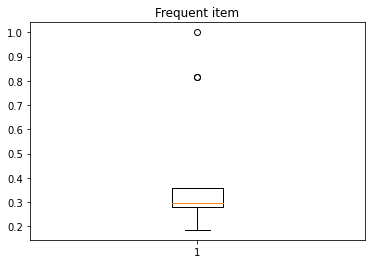

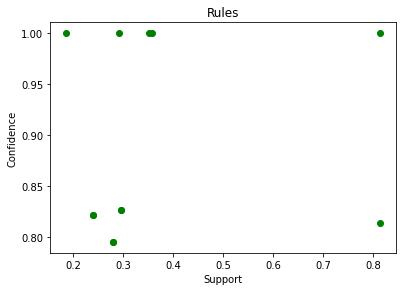

In [78]:
with open("./ocs_result/fterms.json") as f1:
  freq = [json.loads(each) for each in f1.readlines()]
  freq_sup = [each["sup"] for each in freq]
  plt.figure()
  plt.title("Frequent item")
  plt.boxplot(freq_sup)
  plt.show()

with open("./ocs_result/rules.json") as f2:
  rules = [json.loads(each) for each in f2.readlines()]
  rules_sup = [each["sup"] for each in rules]
  rules_conf = [each["conf"] for each in rules]
  fig=plt.figure("rule")
  ax=fig.add_axes([0.1,0.1,0.8,0.8])
  ax.set_title("Rules")
  ax.scatter(rules_sup, rules_conf, marker='o', color='green')
  ax.set_xlabel("Support")
  ax.set_ylabel("Confidence")
  plt.show()

## 挖掘结果分析
### 频繁项集
将频繁项集按照支持度由大到小排序，结果如下：

In [79]:
freq

[{'set': [['Agency', 'OP']], 'sup': 1.0},
 {'set': [['Priority', 2.0]], 'sup': 0.81442},
 {'set': [['Agency', 'OP'], ['Priority', 2.0]], 'sup': 0.81442},
 {'set': [['Area Id', 1.0]], 'sup': 0.35754},
 {'set': [['Area Id', 1.0], ['Agency', 'OP']], 'sup': 0.35754},
 {'set': [['Area Id', 3.0]], 'sup': 0.35092},
 {'set': [['Area Id', 3.0], ['Agency', 'OP']], 'sup': 0.35092},
 {'set': [['Area Id', 1.0], ['Priority', 2.0]], 'sup': 0.29566},
 {'set': [['Agency', 'OP'], ['Area Id', 1.0], ['Priority', 2.0]],
  'sup': 0.29566},
 {'set': [['Area Id', 2.0]], 'sup': 0.29154},
 {'set': [['Area Id', 2.0], ['Agency', 'OP']], 'sup': 0.29154},
 {'set': [['Area Id', 3.0], ['Priority', 2.0]], 'sup': 0.27902},
 {'set': [['Priority', 2.0], ['Area Id', 3.0], ['Agency', 'OP']],
  'sup': 0.27902},
 {'set': [['Area Id', 2.0], ['Priority', 2.0]], 'sup': 0.23974},
 {'set': [['Priority', 2.0], ['Area Id', 2.0], ['Agency', 'OP']],
  'sup': 0.23974},
 {'set': [['Priority', 1.0]], 'sup': 0.18556},
 {'set': [['Priorit

### 关联规则
将关联规则按照置信度由大到小排序，结果如下。
分析可知，Ared Id的置信度最高，说明该地区犯罪事实出现最多，而且Area Id与Priority的关联度较高。

In [80]:
rules

[{'X_set': [['Area Id', 3.0]],
  'Y_set': [['Agency', 'OP']],
  'sup': 0.35092,
  'conf': 1.0,
  'lift': 2.8496523424142253,
  'jaccard': 0.35092000000000007},
 {'X_set': [['Area Id', 2.0]],
  'Y_set': [['Agency', 'OP']],
  'sup': 0.29154,
  'conf': 1.0,
  'lift': 3.4300610550867803,
  'jaccard': 0.2915400000000001},
 {'X_set': [['Priority', 2.0]],
  'Y_set': [['Agency', 'OP']],
  'sup': 0.81442,
  'conf': 1.0,
  'lift': 1.2278676849782666,
  'jaccard': 0.81442},
 {'X_set': [['Area Id', 1.0]],
  'Y_set': [['Agency', 'OP']],
  'sup': 0.35754,
  'conf': 1.0,
  'lift': 2.796889858477373,
  'jaccard': 0.35754},
 {'X_set': [['Priority', 1.0]],
  'Y_set': [['Agency', 'OP']],
  'sup': 0.18556,
  'conf': 1.0,
  'lift': 5.389092476826902,
  'jaccard': 0.18556},
 {'X_set': [['Area Id', 1.0]],
  'Y_set': [['Priority', 2.0]],
  'sup': 0.29566,
  'conf': 0.82692845555742,
  'lift': 2.312827811034905,
  'jaccard': 0.33739586899463647},
 {'X_set': [['Area Id', 1.0]],
  'Y_set': [['Priority', 2.0], ['